In [2]:
import os
import sys
import argparse
import numpy as np
import json
import glob
from pathlib import Path
from tqdm import tqdm

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap


import sys
sys.path.append('/Users/riccardoconci/Local_documents/!!GeomML_2025/GeomMLProj/')
from data_scripts.data_lite import MIMICContrastivePairsDatasetLite
from data_scripts.preprocess_data.get_labels_fast import get_phecode_df

In [5]:

epoch_0_data_path = '/Users/riccardoconci/Local_documents/!!GeomML_2025/GeomMLProj/run_evaluate_contrastive/Embeddings/bs128_lr0.0005_seed42_proj256_temp0.07_phe/viz_embeddings_epoch_0_n257.pkl'
epoch_3_data_path = '/Users/riccardoconci/Local_documents/!!GeomML_2025/GeomMLProj/run_evaluate_contrastive/Embeddings/bs128_lr0.0005_seed42_proj256_temp0.07_phe/viz_embeddings_epoch_3_n4712.pkl'
epoch_7_data_path = '/Users/riccardoconci/Local_documents/!!GeomML_2025/GeomMLProj/run_evaluate_contrastive/Embeddings/bs128_lr0.0005_seed42_proj256_temp0.07_phe/viz_embeddings_epoch_7_n4712.pkl'


# Load the embeddings
with open(epoch_0_data_path, "rb") as f:
    emb_0 = pickle.load(f)

with open(epoch_3_data_path, "rb") as f:
    emb_3 = pickle.load(f)

with open(epoch_7_data_path, "rb") as f:
    emb_7 = pickle.load(f)

# Access the data
hadm_ids = emb_7["hadm_id"]

ts_embeddings_0 = emb_0["ts_embeddings"]
text_embeddings_0 = emb_0["text_embeddings"]

ts_embeddings_3 = emb_3["ts_embeddings"]
text_embeddings_3 = emb_3["text_embeddings"]

ts_embeddings_7 = emb_7["ts_embeddings"]
text_embeddings_7 = emb_7["text_embeddings"]



In [11]:
def prepare_umap_data(ts_emb, text_emb, reducer=None):
    embeddings = np.concatenate([ts_emb, text_emb], axis=0)
    if reducer is None:
        reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
        umap_result = reducer.fit_transform(embeddings)
    else:
        umap_result = reducer.transform(embeddings)
    
    n = len(ts_emb)
    df = pd.DataFrame({
        'x': umap_result[:, 0],
        'y': umap_result[:, 1],
        'modality': ['TS'] * n + ['Text'] * n
    })
    return df, reducer

# Run UMAP on epoch 0 and reuse reducer for later epochs (shared layout)
df0, reducer = prepare_umap_data(ts_embeddings_0, text_embeddings_0)
df3, _ = prepare_umap_data(ts_embeddings_3, text_embeddings_3, reducer)
df7, _ = prepare_umap_data(ts_embeddings_7, text_embeddings_7, reducer)


/Users/riccardoconci/miniforge3/envs/GeomML/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/riccardoconci/miniforge3/envs/GeomML/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/riccardoconci/miniforge3/envs/GeomML/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:

def get_epoch_labels(hadm_ids, dataset):
    mort_labels = []
    readm_labels = []
    nxt_pad_labels = []
    cur_pad_labels = []
    curr_len_list = []
    nxt_len_list = []

    for i in range(len(hadm_ids)):
        mort, readm, cur_pad, cur_len, nxt_pad, nxt_len = dataset._fetch_labels(hadm_ids[i])
        mort_labels.append(mort)
        readm_labels.append(readm)
        nxt_pad_labels.append(nxt_pad)
        cur_pad_labels.append(cur_pad)
        curr_len_list.append(cur_len)
        nxt_len_list.append(nxt_len)

    return {
        "mortality": mort_labels,
        "readmission": readm_labels,
        "cur_pad": cur_pad_labels,
        "nxt_pad": nxt_pad_labels,
        "cur_len": curr_len_list,
        "nxt_len": nxt_len_list,
    }


In [14]:
cache_dir = "/Users/riccardoconci/Local_documents/!!GeomML_2025/GeomMLProj/temp_dfs_lite"
dataset = MIMICContrastivePairsDatasetLite(
    split="val",
    cache_dir=cache_dir,
    task_mode="CONTRASTIVE",
    chunk_hours=12,
    label_window=24,
    T=80,
    test_ds_only=False
)

labels_0 = get_epoch_labels(emb_0["hadm_id"], dataset)
labels_3 = get_epoch_labels(emb_3["hadm_id"], dataset)
labels_7 = get_epoch_labels(emb_7["hadm_id"], dataset)

# Then assign mortality and readmission labels (duplicated for TS and Text)
df0["mortality"] = labels_0["mortality"] * 2
df3["mortality"] = labels_3["mortality"] * 2
df7["mortality"] = labels_7["mortality"] * 2

df0["readmission"] = labels_0["readmission"] * 2
df3["readmission"] = labels_3["readmission"] * 2
df7["readmission"] = labels_7["readmission"] * 2

Loaded baseline dataframe: /Users/riccardoconci/Local_documents/!!GeomML_2025/GeomMLProj/temp_dfs_lite/processed_baseline_df.pkl
Split by subject_id: 69990 train, 28996 val, 1001 test subjects
Corresponding to: 512938 train, 215475 val, 7836 test admissions


Filtering valid hadm_ids: 100%|██████████| 215475/215475 [00:00<00:00, 422372.45it/s]


Filtered 0 invalid hadm_ids, 215475 remaining


In [36]:
def plot_umap_labeled_overlay(dfs, label_col, title_prefix, epoch_labels=None):
    num_plots = len(dfs)
    fig, axs = plt.subplots(1, num_plots, figsize=(7 * num_plots, 6), sharex=True, sharey=True)

    # Ensure axs is iterable
    if num_plots == 1:
        axs = [axs]

    if epoch_labels is None:
        epoch_labels = list(range(num_plots))

    for ax, df, epoch in zip(axs, dfs, epoch_labels):
        ts = df[df.modality == 'TS'].copy()
        txt = df[df.modality == 'Text'].copy()

        ts_color = 'orange'
        txt_color = '#ADD8E6'  # light blue

        base_size = 40
        overlay_size = 10

        # Base scatter plot
        ax.scatter(ts.x, ts.y, c=ts_color, s=base_size, marker='o', alpha=0.8, label='TS', edgecolors='none')
        ax.scatter(txt.x, txt.y, c=txt_color, s=base_size, marker='^', alpha=0.8, label='Text', edgecolors='none')

        # Overlay subtle dot for positives
        ts_pos = ts[ts[label_col] == 1]
        txt_pos = txt[txt[label_col] == 1]

        ax.scatter(ts_pos.x, ts_pos.y, c='black', s=overlay_size, marker='o', alpha=0.9, zorder=3)
        ax.scatter(txt_pos.x, txt_pos.y, c='black', s=overlay_size, marker='o', alpha=0.9, zorder=3)

        # Pairing lines (every 5th for clarity)
        for i in range(0, len(ts), 5):
            ax.plot([ts.x.iloc[i], txt.x.iloc[i]],
                    [ts.y.iloc[i], txt.y.iloc[i]],
                    color='grey', alpha=0.15, linewidth=0.3)

        ax.set_title(f'{title_prefix} — Epoch {epoch}')
        ax.axis('off')

    axs[0].legend()
    plt.suptitle(f'{title_prefix} Embedding Evolution\n(Black dot = Positive Label)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

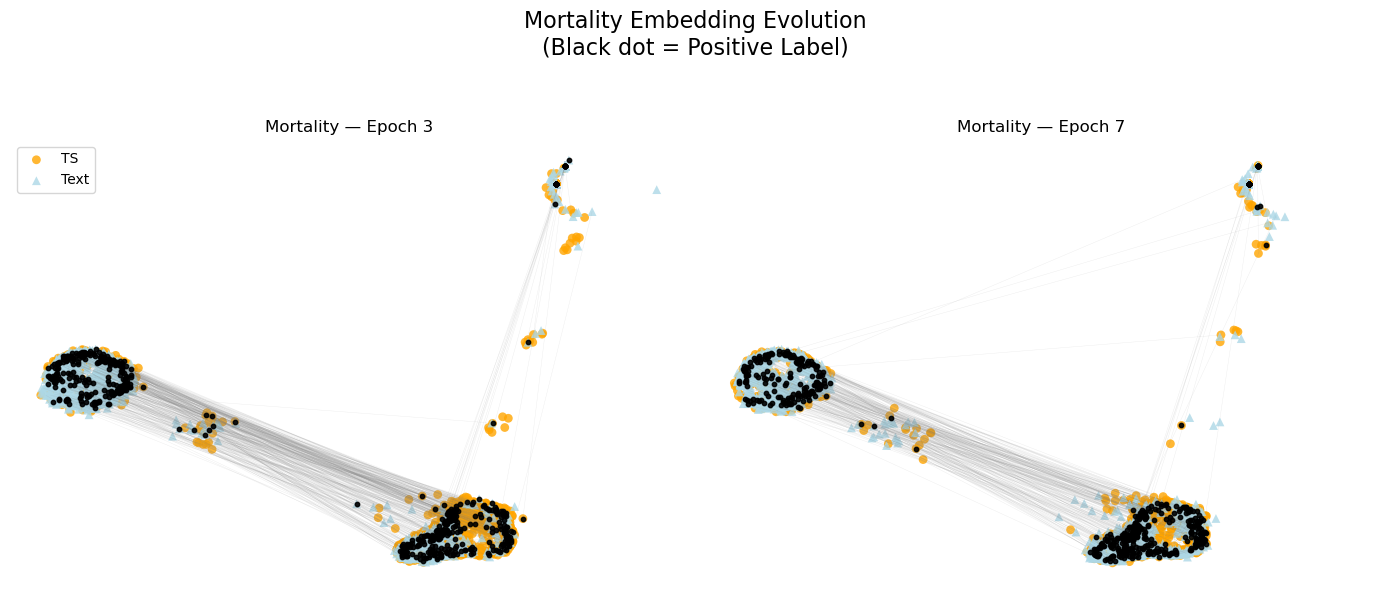

In [41]:
plot_umap_labeled_overlay([df3, df7], label_col='mortality', title_prefix='Mortality', epoch_labels=[3, 7])


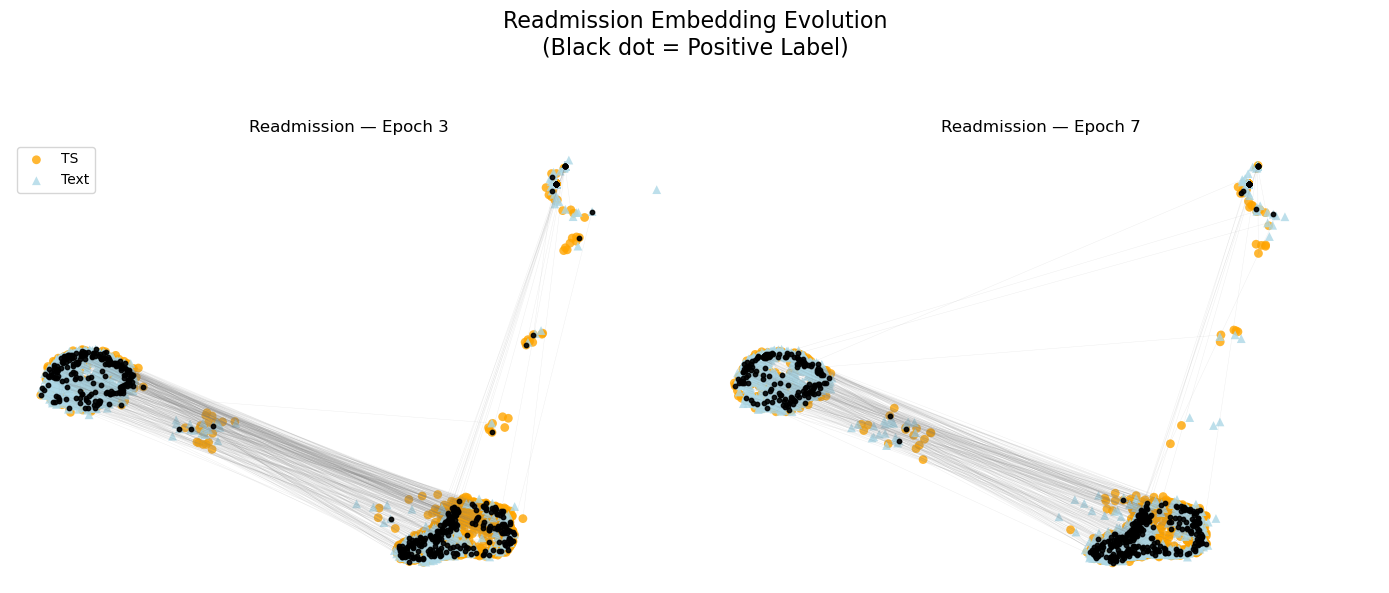

In [40]:
plot_umap_labeled_overlay([df3, df7], label_col='readmission', title_prefix='Readmission', epoch_labels=[3, 7])